Importamos las librerías y cargamos la base de datos

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Número de imágenes de entrenamiento: 148
Número de imágenes de prueba: 40


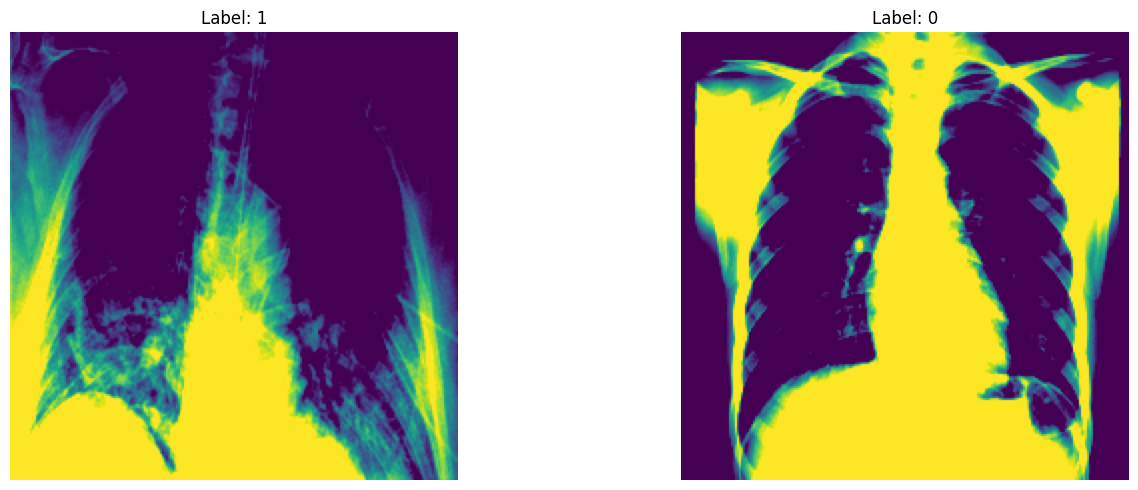

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar a 224x224 píxeles
    transforms.Grayscale(num_output_channels=1),  # Convertir a 1 canal (escala de grises)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485],
                         std=[0.229])
])


class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None, label=0):
        self.data_dir = data_dir
        self.transform = transform
        self.label = label
        self.image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith(('jpeg', 'png', 'jpg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Abrir la imagen en escala de grises
        if self.transform:
            image = self.transform(image)
        return image, self.label

# Cargar los datasets personalizados
train_dataset_normal = CustomDataset('/content/drive/MyDrive/xray_dataset_covid19/train/normal', transform=transform, label=0)
train_dataset_pneumonia = CustomDataset('/content/drive/MyDrive/xray_dataset_covid19/train/pneumonia', transform=transform, label=1)
test_dataset_normal = CustomDataset('/content/drive/MyDrive/xray_dataset_covid19/test/normal', transform=transform, label=0)
test_dataset_pneumonia = CustomDataset('/content/drive/MyDrive/xray_dataset_covid19/test/pneumonia', transform=transform, label=1)

# Combinar los datasets
train_dataset = train_dataset_normal + train_dataset_pneumonia
test_dataset = test_dataset_normal + test_dataset_pneumonia

# Crear DataLoaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificar contenido
print(f"Número de imágenes de entrenamiento: {len(train_dataset)}")
print(f"Número de imágenes de prueba: {len(test_dataset)}")




# Función para mostrar imágenes
def show_images(dataset, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Elegir una imagen aleatoria del dataset
        img, label = dataset[np.random.randint(0, len(dataset))]
        # Desnormalizar la imagen para visualizar correctamente
        img = img.numpy().transpose(1, 2, 0)  # Cambiar la forma (C, H, W) -> (H, W, C)
        img = np.clip(img, 0, 1)

        # Mostrar la imagen
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Mostrar 2 imágenes del dataset de entrenamiento
show_images(train_dataset, num_images=2)






Procedemos a la construcción del modelo


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Capa completamente conectada ajustada
        self.fc1 = nn.Linear(32 * 54 * 54, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # Aplanar y pasar por la capa completamente conectada
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x



# Crea el modelo
model = SimpleNetwork()





Entrenamiento

Época 1/10: 100%|██████████| 5/5 [00:15<00:00,  3.00s/lote, loss=0.923]


Época [1/10], Pérdida: 0.9233, Precisión: 71.62%
Precisión en el conjunto de prueba: 95.00%


Época 2/10: 100%|██████████| 5/5 [00:14<00:00,  2.87s/lote, loss=0.178]


Época [2/10], Pérdida: 0.1779, Precisión: 95.95%
Precisión en el conjunto de prueba: 95.00%


Época 3/10: 100%|██████████| 5/5 [00:14<00:00,  2.88s/lote, loss=0.124]


Época [3/10], Pérdida: 0.1238, Precisión: 95.95%
Precisión en el conjunto de prueba: 95.00%


Época 4/10: 100%|██████████| 5/5 [00:14<00:00,  2.84s/lote, loss=0.174]


Época [4/10], Pérdida: 0.1742, Precisión: 96.62%
Precisión en el conjunto de prueba: 97.50%


Época 5/10: 100%|██████████| 5/5 [00:14<00:00,  2.83s/lote, loss=0.131]


Época [5/10], Pérdida: 0.1312, Precisión: 94.59%
Precisión en el conjunto de prueba: 97.50%


Época 6/10: 100%|██████████| 5/5 [00:14<00:00,  2.90s/lote, loss=0.0556]


Época [6/10], Pérdida: 0.0556, Precisión: 98.65%
Precisión en el conjunto de prueba: 97.50%


Época 7/10: 100%|██████████| 5/5 [00:14<00:00,  2.86s/lote, loss=0.0295]


Época [7/10], Pérdida: 0.0295, Precisión: 99.32%
Precisión en el conjunto de prueba: 95.00%


Época 8/10: 100%|██████████| 5/5 [00:14<00:00,  2.83s/lote, loss=0.0149]


Época [8/10], Pérdida: 0.0149, Precisión: 100.00%
Precisión en el conjunto de prueba: 97.50%


Época 9/10: 100%|██████████| 5/5 [00:14<00:00,  2.89s/lote, loss=0.0166]


Época [9/10], Pérdida: 0.0166, Precisión: 99.32%
Precisión en el conjunto de prueba: 97.50%


Época 10/10: 100%|██████████| 5/5 [00:14<00:00,  2.88s/lote, loss=0.0121]


Época [10/10], Pérdida: 0.0121, Precisión: 99.32%
Precisión en el conjunto de prueba: 97.50%


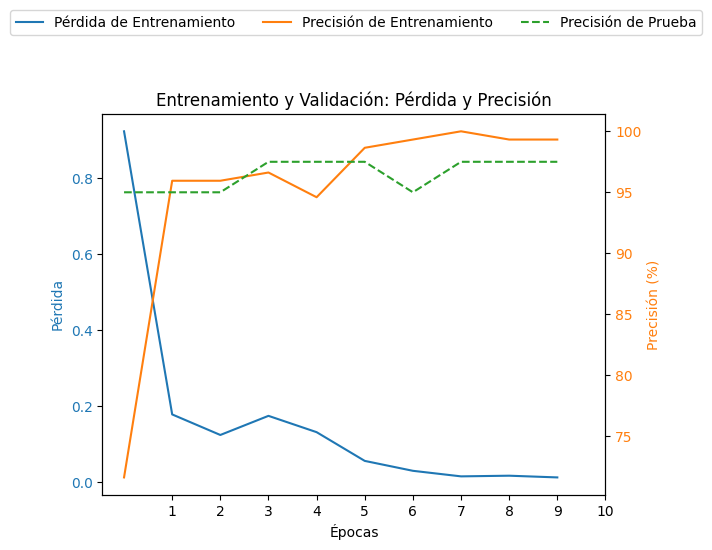

Modelo guardado como modelo_entrenado.pth


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Cargar los datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Definir la red y otros parámetros
model = SimpleNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs, batches_per_epoch):
    model.train()  # Establece el modelo en modo de entrenamiento

    # Listas para almacenar las métricas
    train_losses, train_accuracies = [], []
    test_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Barra de progreso para el entrenamiento
        with tqdm(train_loader, desc=f"Época {epoch + 1}/{num_epochs}", unit="lote", total=batches_per_epoch) as pbar:
            for i, (images, labels) in enumerate(train_loader):
                if i >= batches_per_epoch:
                    break  # Detenemos después del número deseado de lotes por época

                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs.view(-1), labels.float())
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                predicted = outputs.round()
                correct_predictions += (predicted.view(-1) == labels).sum().item()
                total_samples += labels.size(0)

                # Actualizar la barra de progreso con la pérdida actual
                pbar.set_postfix(loss=running_loss / total_samples)
                pbar.update(1)  # Avanzar manualmente en la barra de progreso

        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Época [{epoch+1}/{num_epochs}], Pérdida: {epoch_loss:.4f}, Precisión: {epoch_accuracy:.2f}%")

        # Evaluación del modelo en el conjunto de prueba
        model.eval()  # Establece el modelo en modo de evaluación
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():  # No calcular gradientes durante la evaluación
            for images, labels in test_loader:
                images, labels = images.to(), labels.to()
                outputs = model(images)
                predicted = outputs.round()
                correct_predictions += (predicted.view(-1) == labels).sum().item()
                total_samples += labels.size(0)

        test_accuracy = correct_predictions / total_samples * 100
        test_accuracies.append(test_accuracy)
        print(f"Precisión en el conjunto de prueba: {test_accuracy:.2f}%")

    # Graficar resultados
    plot_metrics(train_losses, train_accuracies, test_accuracies)

# Función para graficar las métricas
def plot_metrics(train_losses, train_accuracies, test_accuracies):
    # Crear figura
    fig, ax1 = plt.subplots()

    # Gráfico de la pérdida
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida', color='tab:blue')
    loss_line, = ax1.plot(train_losses, color='tab:blue', label='Pérdida de Entrenamiento')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Gráfico de la precisión
    ax2 = ax1.twinx()
    ax2.set_ylabel('Precisión (%)', color='tab:orange')
    acc_train_line, = ax2.plot(train_accuracies, color='tab:orange', label='Precisión de Entrenamiento')
    acc_test_line, = ax2.plot(test_accuracies, color='tab:green', label='Precisión de Prueba', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Configurar eje X para mostrar solo enteros
    epochs = range(1, len(train_losses)+1)
    ax1.set_xticks(epochs)  # Coloca las marcas en el eje X
    ax1.set_xticklabels(epochs)  # Etiquetas como números enteros


    # Leyendas en la parte superior
    fig.legend(
        [loss_line, acc_train_line, acc_test_line],
        ['Pérdida de Entrenamiento', 'Precisión de Entrenamiento', 'Precisión de Prueba'],
        loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3
    )

    # Ajustar el diseño
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Reducir espacio para la leyenda en la parte superior
    plt.title("Entrenamiento y Validación: Pérdida y Precisión")
    plt.show()


# Entrenar el modelo con 5 lotes por época
train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, batches_per_epoch=5)

# Guardar los pesos del modelo entrenado
torch.save(model.state_dict(), "modelo_entrenado.pth")
print("Modelo guardado como modelo_entrenado.pth")







Evaluamos por medio de un while para visualizar el funcionamiento del modelo

In [ ]:
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np

# Cargar los pesos del modelo guardado
model.load_state_dict(torch.load('modelo_entrenado.pth'))
model.eval()  # Asegúrate de poner el modelo en modo evaluación

# Función para realizar predicciones
def predict(model, image):
    # Asegúrate de que la imagen esté preparada correctamente
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=1),  # Asegúrate de que la imagen tenga 1 canal
        transforms.Normalize(mean=[0.485], std=[0.229]),
    ])

    # Si la imagen ya es un tensor, no aplicar ToTensor, solo las demás transformaciones
    if isinstance(image, torch.Tensor):
        image = image.unsqueeze(0)  # Añadir la dimensión del batch
    else:
        image = transform(image).unsqueeze(0)  # Convertir la imagen a un tensor y agregar la dimensión del batch

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        output = model(image)
    return output


# Función para mostrar una imagen
def show_image(img_tensor, label):
    img = img_tensor.numpy().transpose(1, 2, 0)  # Cambiar de (C, H, W) a (H, W, C)

    plt.imshow(img)
    plt.title(f"Etiqueta: {'Enfermo' if label.item() == 1 else 'Sano'}")
    plt.axis('off')  # Eliminar los ejes para una vista limpia
    plt.show()


def predictor():
    # Seleccionar un batch aleatorio del test_loader
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Elegir una imagen aleatoria del batch
    random_idx = random.randint(0, len(images) - 1)
    image = images[random_idx]
    label = labels[random_idx]

    # Mostrar la imagen y etiqueta
    show_image(image, label)

    # Realizar la predicción con el modelo
    output = predict(model, image)
    print(f"Predicción del modelo: {output.item()}")

    # Clasificación final basada en el umbral de 0.5
    predicted_label = 1 if output.item() > 0.5 else 0
    print(f"Clase predicha: {'Enfermo' if predicted_label == 1 else 'Sano'}")

    # Comprobar si la predicción coincide con la etiqueta real
    if predicted_label == label.item():
        print("La predicción coincide con la etiqueta real.")
    else:
        print("La predicción no coincide con la etiqueta real.")

    return predicted_label, label.item()


# Inicializar las variables antes del ciclo, mismo valor para que cumple la condición del bucle
predicted_label = 912
label = 912

# Bucle hasta que la predicción no coincida con la etiqueta real
while predicted_label == label:
  predicted_label, label = predictor()




